<a href="https://www.kaggle.com/code/taidinh5/qvi-data-analytics-task-two?scriptVersionId=255518201" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>



<h1 style="font-family:verdana; font-weight:bold;""> <center> Quantium Virtual Internship: Task Two </center> </h1>
<p><center font-family:cursive;">Author: Tai Dinh</center></p>

***


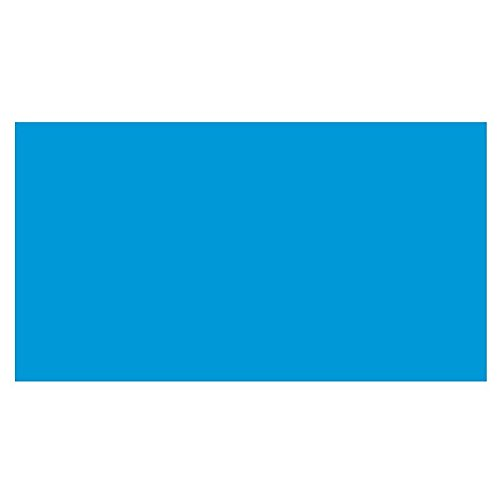
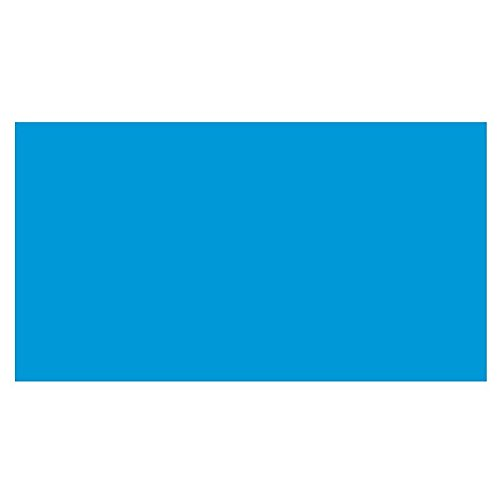
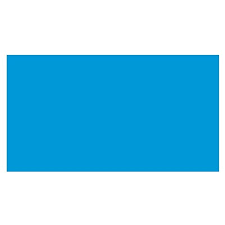

<div style="height:5px; background-color:#0096FF;"></div>


<h2 style="font-family:verdana; font-weight: bold;""> 1. Background Information  </h2>

<div style="background-color:#f0f8ff; padding:15px; border-left:5px solid #0096FF; font-family:Verdana; font-size:14px;">
  <b>🖼️ Business Objective:</b><br>
  As part of Quantium’s Retail Analytics Team, I was approached by the Chips Category Manager to test the impact of <b>new trial layouts</b> with a data recommendation to whether or not the trial layout should be rolled out to all their stores.
</div>


<div style="background-color:#f0f8ff; padding:15px; border-left:5px solid #0096FF; font-family:Verdana; font-size:14px;">
  <b>📌 Project Tasks:</b><br>
  •&nbsp; Select control stores - for each trial store (77,86,88), find a similar non-trial store to compare against.<br>
  •&nbsp; Compare performance - check each trial store in comparison with control store to see if trial stores were successful or not.<br>
  •&nbsp; Collate findings - Summarize findings for store and provide recommendation to keep or cancel the new layout.<br>
  •&nbsp; Draw visualizations - create and save visualizations for final report.<br>
</div>



<div style="height:5px; background-color:#0096FF;"></div>


<h2 style="font-family:verdana; font-weight: bold;""> 2. Import Necessary Libraries & Datasets  </h2>

In [ ]:
# Step 1: Install package(s) 
install.packages("data.table")
install.packages("tidyverse")
install.packages("lubridate")

# Step 2: Load libraries
library(data.table)
library(tidyverse)
library(lubridate) 

# (OPTIONAL) Step 3: Set file path (if running R on local RStudio on Windows machine)
# [ABSOLUTE PATH] filePath <- "C:/Users/YourName/Downloads/my_dataset.csv"
# [RELATIVE PATH] filePath <- "subfolder/my_dataset.csv"
# setwd("C:/Users/YourName/Downloads/my_dataset.csv")

# Step 4: Load data
task2Data <- read_csv("/kaggle/input/mergeddata/QVI_data_task2.csv")
setDT(task2Data)  #converts data frame to data table 

# Set Themes for Plots
theme_set(theme_bw())
theme_update(plot.title = element_text(hjust = 0.5))

<div style="height:5px; background-color:#0096FF;"></div>


<h2 style="font-family:verdana; font-weight: bold;""> 3. Select Control Stores  </h2>

<div style="background-color:#f0f8ff; padding:15px; border-left:5px solid #0096FF; font-family:Verdana; font-size:14px;">
  <b>🛒 Setting Up For Comparison:</b><br>
  In this stage, the client selected store numbers 77, 86 and 88 as trial stores and want control stores to be established stores that are operational for the entire observation period. We want control stores to be similar to trial stores prior to the trial period of Feb 2019 in terms of several metrics: 
    <br><br>1. Monhtly overall sales revenue<br> 
    2. Monthly number of customers<br> 
    3. Monthly number of transactions per customer<br>
</div>


<div style="background-color:#f0f8ff; padding:15px; border-left:5px solid #0096FF; font-family:Verdana; font-size:14px; text-align:center;">
  <b>🔍 First, create metrics of interest and filter to stores that are present throughout the pre-trial period  🔍 </b><br>
</div>

In [ ]:
# Create Month ID Column in format YYYYMM
task2Data[, YEARMONTH := as.integer(format(DATE, "%Y%m"))]   # extracts year and month from DATE column and stores as integer 

In [ ]:
# Calculate Monthly Pre-Trial Metrics per Store 
measureOverTime <- task2Data[, .(                                 # DT[filter,select,group] -> DT[, .(metrics), by = .(Store, Month)]
    totSales = sum(TOT_SALES),                                    # total sales by store per month
    nCust = uniqueN(LYLTY_CARD_NBR),                              # number of unique customers
    nTxnPerCust = .N / uniqueN(LYLTY_CARD_NBR),                   # avg num of transactions per customer
    nChipsPerTxn = sum(PROD_QTY) / .N,                            # avg quantity of chips per transaction
    avgPricePerUnit = sum(TOT_SALES) / sum(PROD_QTY)              # avg price per unit
), by = .(STORE_NBR, YEARMONTH)][order(STORE_NBR, YEARMONTH)]    # order by store num and month in ASC order

measureOverTime

In [ ]:
# Identify stores with full 12 months of data
storesWithFullObs <- unique(measureOverTime[, .N, STORE_NBR] [N == 12, STORE_NBR])

storesWithFullObs
print("Store ID 1 to 272 have full 12-Month pre-trial observations EXCEPT for the following stores:")

# (OPTIONAL) Find the stores that don't have 12 months of data
allStores <- 1:272
missingStores <- setdiff(allStores, storesWithFullObs)
print(missingStores)

# Filter stores with full 12 months of dat AND before February 2019
preTrialMeasures <- measureOverTime[YEARMONTH < 201902 & STORE_NBR %in% storesWithFullObs, ]

preTrialMeasures

<div style="background-color:#f0f8ff; padding:15px; border-left:5px solid #0096FF; font-family:Verdana; font-size:14px; text-align:center;">
  <b>⚙️ Correlation Function ⚙️ </b><br>
  Let's rank how similar each potential control store is to the trial store. We can calculate the performance correlation of each control store to the trial store.
</div>

In [ ]:
correlationFunction <- function(preTrialMeasures, metricCol, storeComparison) {
  storeNumbers <- unique(preTrialMeasures$STORE_NBR)                  # get all store numbers from the table
  storeNumbers <- storeNumbers[storeNumbers != storeComparison]       # remove the trial store (bc we're comparing to this store, so don't include)      
   
  calcCorrTable <- data.table(trialStore = numeric(),                       # create an empty table to store correlation results
                              cntrlStore = numeric(),                       # holds: trial store number, control store number, and correlation
                              corrMeasure = numeric())  
    
  trialStoreData <- as.numeric(preTrialMeasures[STORE_NBR == storeComparison, eval(metricCol)]) # retrieve metric values for trial store (e.g."totSales") 
  
  for (i in storeNumbers) {                                                 # loops through each control store to compare with trial store
    controlStoreData <- as.numeric(preTrialMeasures[STORE_NBR == i, eval(metricCol)])              # retrieve metric values from control stores
    correlationValue <- cor(trialStoreData, controlStoreData, use = "complete.obs")    # calculates correlation b/w trial & control store
    calculatedMeasure <- data.table(trialStore = storeComparison,           # saves correlation result into a small table
                                    cntrlStore = i,
                                    corrMeasure = correlationValue)   
    calcCorrTable <- rbind(calcCorrTable, calculatedMeasure)                # add this row to the main results table
  }
  return(calcCorrTable)                                                     # return the full table of correlations
}

correlationTable <- correlationFunction(preTrialMeasures, quote(totSales), 77)   # comparing correlation with trial store 77 as example in total sales
print(correlationTable)

<div style="background-color:#f0f8ff; padding:15px; border-left:5px solid #0096FF; font-family:Verdana; font-size:14px; text-align:center;">
  <b>⚙️ Magnitude Distance Function ⚙️ </b><br>
  We can also measure how similar each control store is to the trial store by calculating a standardized metric based on the absolute difference in their performance.
</div>

In [ ]:
magnitudeDistanceFunction <- function(preTrialMeasures, metricCol, storeComparison) {     # function to calculate a standardized magnitude distance
 
  calcDistTable = data.table(trialStore = numeric(), cntrlStore = numeric(), YEARMONTH = numeric(), measure = numeric())# small table to store results
  storeNumbers <- unique(preTrialMeasures[, STORE_NBR])    # get unique store numbers from the data
  
  for (i in storeNumbers) {                   # loops through each store to compare with trial store
    calculatedMeasure = data.table(           # calculates the absolute diff in metric b/w trial and current store
      "trialStore" = storeComparison,     # trial store                       
      "cntrlStore" = i,                   # current store being compared with
      "YEARMONTH" = preTrialMeasures[STORE_NBR == storeComparison, YEARMONTH],      # get the dates
      "measure" = abs(preTrialMeasures[STORE_NBR == storeComparison, eval(metricCol)] - preTrialMeasures[STORE_NBR == i, eval(metricCol)])
    )              #absolute diff
    calcDistTable <- rbind(calcDistTable, calculatedMeasure)     # add the result to the main distance table
  }

  # Standardise the magnitude distance so that the measure ranges from 0 to 1
  minMaxDist <- calcDistTable[, .(minDist = min(measure), maxDist = max(measure)),     # get min/max distance measure for each YEARMONTH and Store1
                              by = c("trialStore", "YEARMONTH")]   
  
  distTable <- merge(calcDistTable, minMaxDist, by = c("trialStore", "YEARMONTH"))         # merge the distance table with the min/max values
  distTable[, magnitudeMeasure := 1 - (measure - minDist)/(maxDist - minDist)]         # standardize the measure b/w 0 and 1 (higher = more similar)
  
  finalDistTable <- distTable[, .(magMeasure = mean(magnitudeMeasure)), by = .(trialStore, cntrlStore)] # average the standardized values for each store pair
  return(finalDistTable)
}

magnitudeTable <- magnitudeDistanceFunction(preTrialMeasures, quote(totSales), 77)
print(magnitudeTable)

<div style="background-color:#f0f8ff; padding:15px; border-left:5px solid #0096FF; font-family:Verdana; font-size:14px; text-align:center;">
  🔍 Now, we'll use the correlationFunction and magnitudeDistanceFunction to find the control stores. We’ll pick stores that have similar monthly sales and customer numbers to the trial store. So, we’ll calculate four scores - two for sales and two for customer counts. 🔍
</div>

<div style="background-color:#f0f8ff; padding:15px; border-left:5px solid #0096FF; font-family:Verdana; font-size:14px; text-align:center;">
  🔍 Find Trial Store 77's Control Store 🔍
</div>

In [ ]:
# Trial Store 77
trial_store77 <- 77

# Correlation: total sales and number of customers
corrNsales77 <- correlationFunction(preTrialMeasures, quote(totSales), trial_store77)
corrNcustomers77 <- correlationFunction(preTrialMeasures, quote(nCust), trial_store77)

# Magnitude distance: total sales and number of customers
magnitudeNsales77 <- magnitudeDistanceFunction(preTrialMeasures, quote(totSales), trial_store77)
magnitudeNcustomers77 <- magnitudeDistanceFunction(preTrialMeasures, quote(nCust), trial_store77)

In [ ]:
# 1. Combine correlation and magnitude for total sales and number of customers (Trial Store 77)
corrWeight <- 0.5

                      # combine for total sales
score_nSales77 <- merge(corrNsales77, magnitudeNsales77, by = "cntrlStore")
score_nSales77[, scoreNSales77 := corrWeight * corrMeasure + (1 - corrWeight) * magMeasure]

                      # combine for number of customers
score_nCustomers77 <- merge(corrNcustomers77, magnitudeNcustomers77, by = "cntrlStore")
score_nCustomers77[, scoreNCust77 := corrWeight * corrMeasure + (1 - corrWeight) * magMeasure]

# 2. Combine scores for both drivers into a final score
score_Control77 <- merge(score_nSales77[, .(cntrlStore, scoreNSales77)],
                       score_nCustomers77[, .(cntrlStore, scoreNCust77)],
                       by = "cntrlStore")
score_Control77[, finalControlScore77 := 0.5 * scoreNSales77 + 0.5 * scoreNCust77]

# 3. Select the best control store
control_store77 <- score_Control77[cntrlStore != trial_store77][order(-finalControlScore77)][1, cntrlStore]   # after sorting by desc order, it selects first row (highest score)

print(control_store77)

In [ ]:
# Check the stats for control store 233 (Trial Store 77)
control233stats <- score_Control77[cntrlStore == 233]
print(control233stats)

<div style="background-color:#f0f8ff; padding:15px; border-left:5px solid #0096FF; font-family:Verdana; font-size:14px; text-align:center;">
  🔍 Find Trial Store 86's Control Store 🔍
</div>

In [ ]:
# Trial Store 86
trial_store86 <- 86

# Correlation: total sales and number of customers
corrNsales86 <- correlationFunction(preTrialMeasures, quote(totSales), trial_store86)
corrNcustomers86 <- correlationFunction(preTrialMeasures, quote(nCust), trial_store86)

# Magnitude distance: total sales and number of customers
magnitudeNsales86 <- magnitudeDistanceFunction(preTrialMeasures, quote(totSales), trial_store86)
magnitudeNcustomers86 <- magnitudeDistanceFunction(preTrialMeasures, quote(nCust), trial_store86)

In [ ]:
# 1. Combine correlation and magnitude for total sales and number of customers (Trial Store 86)
corrWeight <- 0.5

                      # combine for total sales
score_nSales86 <- merge(corrNsales86, magnitudeNsales86, by = "cntrlStore")
score_nSales86[, scoreNSales86 := corrWeight * corrMeasure + (1 - corrWeight) * magMeasure]

                      # combine for number of customers
score_nCustomers86 <- merge(corrNcustomers86, magnitudeNcustomers86, by = "cntrlStore")
score_nCustomers86[, scoreNCust86 := corrWeight * corrMeasure + (1 - corrWeight) * magMeasure]

# 2. Combine scores for both drivers into a final score
score_Control86 <- merge(score_nSales86[, .(cntrlStore, scoreNSales86)],
                       score_nCustomers86[, .(cntrlStore, scoreNCust86)],
                       by = "cntrlStore")
score_Control86[, finalControlScore86 := 0.5 * scoreNSales86 + 0.5 * scoreNCust86]

# 3. Select the best control store
control_store86 <- score_Control86[cntrlStore != trial_store86][order(-finalControlScore86)][1, cntrlStore]   # after sorting by desc order, it selects first row (highest score)

print(control_store86)

In [ ]:
# Check the stats for control store 155 (Trial Store 86)
control155stats <- score_Control86[cntrlStore == 155]
print(control155stats)

<div style="background-color:#f0f8ff; padding:15px; border-left:5px solid #0096FF; font-family:Verdana; font-size:14px; text-align:center;">
  🔍 Find Trial Store 88's Control Store 🔍
</div>

In [ ]:
# Trial Store 88
trial_store88 <- 88

# Correlation: total sales and number of customers
corrNsales88 <- correlationFunction(preTrialMeasures, quote(totSales), trial_store88)
corrNcustomers88 <- correlationFunction(preTrialMeasures, quote(nCust), trial_store88)

# Magnitude distance: total sales and number of customers
magnitudeNsales88 <- magnitudeDistanceFunction(preTrialMeasures, quote(totSales), trial_store88)
magnitudeNcustomers88 <- magnitudeDistanceFunction(preTrialMeasures, quote(nCust), trial_store88)

In [ ]:
# 1. Combine correlation and magnitude for total sales and number of customers (Trial Store 88)
corrWeight <- 0.5

                      # combine for total sales
score_nSales88 <- merge(corrNsales88, magnitudeNsales88, by = "cntrlStore")
score_nSales88[, scoreNSales88 := corrWeight * corrMeasure + (1 - corrWeight) * magMeasure]

                      # combine for number of customers
score_nCustomers88 <- merge(corrNcustomers88, magnitudeNcustomers88, by = "cntrlStore")
score_nCustomers88[, scoreNCust88 := corrWeight * corrMeasure + (1 - corrWeight) * magMeasure]

# 2. Combine scores for both drivers into a final score
score_Control88 <- merge(score_nSales88[, .(cntrlStore, scoreNSales88)],
                       score_nCustomers88[, .(cntrlStore, scoreNCust88)],
                       by = "cntrlStore")
score_Control88[, finalControlScore88 := 0.5 * scoreNSales88 + 0.5 * scoreNCust88]

# 3. Select the best control store
control_store88 <- score_Control88[cntrlStore != trial_store88][order(-finalControlScore88)][1, cntrlStore]   # after sorting by desc order, it selects first row (highest score)

print(control_store88)

In [ ]:
# Check the stats for control store 237 (Trial Store 88)
control237stats <- score_Control88[cntrlStore == 237]
print(control237stats)

<div style="background-color:#f0f8ff; padding:15px; border-left:5px solid #0096FF; font-family:Verdana; font-size:14px; text-align:center;">
  <b>🔍 Now that we have found a control store for each trial store (77,86,88), let's verify visually if the drivers are indeed similar in the period before the trial. 🔍 </b><br>
</div>

In [ ]:
# Trial Store 77 | Control Store 233

# Visual Check on total sales trends
measureOverTimeSales77 <- copy(measureOverTime)
pastSales77 <- measureOverTimeSales77[, Store_type := ifelse(STORE_NBR == trial_store77,              # label each row by store type: Trial, Control, Other
                                                          "Trial Store 77",
                                                          ifelse(STORE_NBR == control_store77,
                                                                 "Control Store 233", "Other stores"))
][, totSales := mean(totSales), by = c("YEARMONTH", "Store_type")                              # calc avg total sales by month and store type
][, TransactionMonth := as.Date(paste0(YEARMONTH, "01"), "%Y%m%d")                             # convert YEARMONTH into date format
][YEARMONTH < 201903 , ]                                                                       # keep only dates before March 2019

ggplot(pastSales77, aes(TransactionMonth, totSales, color = Store_type)) +
  geom_line() +
  scale_x_date(date_breaks = "1 month", date_labels = "%b %Y") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(x = "Month of operation", y = "Total sales", title = "Total sales by month")


# Visual Check on customer count trends
measureOverTimeCusts77 <- copy(measureOverTime)
pastCustomers77 <- measureOverTimeCusts77[, Store_type := ifelse(STORE_NBR == trial_store77,          # label each row by store type: Trial, Control, Other
                                                              "Trial Store 77",
                                                              ifelse(STORE_NBR == control_store77,
                                                                     "Control Store 233", "Other stores"))
][, nCust := mean(nCust), by = c("YEARMONTH", "Store_type")                                    # calc avg customer count by month and store type
][, TransactionMonth := as.Date(paste0(YEARMONTH, "01"), "%Y%m%d")                             # convert YEARMONTH into date format 
][YEARMONTH < 201903 , ]                                                                       # keep only dates nefore March 2019        

ggplot(pastCustomers77, aes(TransactionMonth, nCust, color = Store_type)) +
  geom_line() +
  scale_x_date(date_breaks = "1 month", date_labels = "%b %Y") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(x = "Month of operation", y = "Number of customers", title = "Customer count by month")

In [ ]:
# Trial Store 86 | Control Store 155

# Visual Check on total sales trends
measureOverTimeSales86 <- copy(measureOverTime)
pastSales86 <- measureOverTimeSales86[, Store_type := ifelse(STORE_NBR == trial_store86,              # label each row by store type: Trial, Control, Other
                                                          "Trial Store 86",
                                                          ifelse(STORE_NBR == control_store86,
                                                                 "Control Store 155", "Other stores"))
][, totSales := mean(totSales), by = c("YEARMONTH", "Store_type")                              # calc avg total sales by month and store type
][, TransactionMonth := as.Date(paste0(YEARMONTH, "01"), "%Y%m%d")                             # convert YEARMONTH into date format
][YEARMONTH < 201903 , ]                                                                       # keep only dates before March 2019

ggplot(pastSales86, aes(TransactionMonth, totSales, color = Store_type)) +
  geom_line() +
  scale_x_date(date_breaks = "1 month", date_labels = "%b %Y") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(x = "Month of operation", y = "Total sales", title = "Total sales by month")


# Visual Check on customer count trends
measureOverTimeCusts86 <- copy(measureOverTime)
pastCustomers86 <- measureOverTimeCusts86[, Store_type := ifelse(STORE_NBR == trial_store86,          # label each row by store type: Trial, Control, Other
                                                              "Trial Store 86",
                                                              ifelse(STORE_NBR == control_store86,
                                                                     "Control Store 155", "Other stores"))
][, nCust := mean(nCust), by = c("YEARMONTH", "Store_type")                                    # calc avg customer count by month and store type
][, TransactionMonth := as.Date(paste0(YEARMONTH, "01"), "%Y%m%d")                             # convert YEARMONTH into date format 
][YEARMONTH < 201903 , ]                                                                       # keep only dates nefore March 2019        

ggplot(pastCustomers86, aes(TransactionMonth, nCust, color = Store_type)) +
  geom_line() +
  scale_x_date(date_breaks = "1 month", date_labels = "%b %Y") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(x = "Month of operation", y = "Number of customers", title = "Customer count by month")

In [ ]:
# Trial Store 88 | Control Store 237

# Visual Check on total sales trends
measureOverTimeSales88 <- copy(measureOverTime)
pastSales88 <- measureOverTimeSales88[, Store_type := ifelse(STORE_NBR == trial_store88,              # label each row by store type: Trial, Control, Other
                                                          "Trial Store 88",
                                                          ifelse(STORE_NBR == control_store88,
                                                                 "Control Store 237", "Other stores"))
][, totSales := mean(totSales), by = c("YEARMONTH", "Store_type")                              # calc avg total sales by month and store type
][, TransactionMonth := as.Date(paste0(YEARMONTH, "01"), "%Y%m%d")                             # convert YEARMONTH into date format
][YEARMONTH < 201903 , ]                                                                       # keep only dates before March 2019

ggplot(pastSales88, aes(TransactionMonth, totSales, color = Store_type)) +
  geom_line() +
  scale_x_date(date_breaks = "1 month", date_labels = "%b %Y") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(x = "Month of operation", y = "Total sales", title = "Total sales by month")


# Visual Check on customer count trends
measureOverTimeCusts88 <- copy(measureOverTime)
pastCustomers88 <- measureOverTimeCusts88[, Store_type := ifelse(STORE_NBR == trial_store88,          # label each row by store type: Trial, Control, Other
                                                              "Trial Store 88",
                                                              ifelse(STORE_NBR == control_store88,
                                                                     "Control Store 237", "Other stores"))
][, nCust := mean(nCust), by = c("YEARMONTH", "Store_type")                                    # calc avg customer count by month and store type
][, TransactionMonth := as.Date(paste0(YEARMONTH, "01"), "%Y%m%d")                             # convert YEARMONTH into date format 
][YEARMONTH < 201903 , ]                                                                       # keep only dates nefore March 2019        

ggplot(pastCustomers88, aes(TransactionMonth, nCust, color = Store_type)) +
  geom_line() +
  scale_x_date(date_breaks = "1 month", date_labels = "%b %Y") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(x = "Month of operation", y = "Number of customers", title = "Customer count by month")

<div style="height:5px; background-color:#0096FF;"></div>


<h2 style="font-family:verdana; font-weight: bold;""> 4. Assessment of Trial  </h2>

<div style="background-color:#f0f8ff; padding:15px; border-left:5px solid #0096FF; font-family:Verdana; font-size:14px;">
  <b>🔬 Comparison Begins:</b><br>
  The trial period goes from the beginning of February 2019 to April 2019.
</div>


<div style="background-color:#f0f8ff; padding:15px; border-left:5px solid #0096FF; font-family:Verdana; font-size:14px; text-align:center;">
  <b>👨‍💻 Assessing Sales 👨‍💻  </b><br>
  We want to see if there's been an uplift in overall chip sales. First, we'll scale the control store's sale to match the trial store's sales before the trial period, so they're comparable
</div>

<div style="background-color:#f0f8ff; padding:15px; border-left:5px solid #0096FF; font-family:Verdana; font-size:14px; text-align:center;">
  🔍 Scale Trial Store 77 & Control Store 233 🔍
</div>

In [ ]:
# Scale pre-trial control sales to match pre-trial trial store sales
scalingFactorForControlSales77 <- preTrialMeasures[STORE_NBR == trial_store77 & YEARMONTH < 201902, sum(totSales)] / 
                                preTrialMeasures[STORE_NBR == control_store77 & YEARMONTH < 201902, sum(totSales)]   
                                                                  # calcs total sales for trial and control stores before Feb 2019
# Apply the scaling factor
measureOverTimeSales77scaled <- copy(measureOverTime)
scaledControlSales77 <- measureOverTimeSales77scaled[STORE_NBR == control_store77, ][, controlSales77 := totSales * scalingFactorForControlSales77]
                                                                            # filter only control store rows, and apply scaling factor to its sales

<div style="background-color:#f0f8ff; padding:15px; border-left:5px solid #0096FF; font-family:Verdana; font-size:14px; text-align:center;">
  🔍 Scale Trial Store 86 & Control Store 155 🔍
</div>

In [ ]:
# Scale pre-trial control sales to match pre-trial trial store sales
scalingFactorForControlSales86 <- preTrialMeasures[STORE_NBR == trial_store86 & YEARMONTH < 201902, sum(totSales)] / 
                                preTrialMeasures[STORE_NBR == control_store86 & YEARMONTH < 201902, sum(totSales)]   
                                                                  # calcs total sales for trial and control stores before Feb 2019
# Apply the scaling factor
measureOverTimeSales86scaled <- copy(measureOverTime)
scaledControlSales86 <- measureOverTimeSales86scaled[STORE_NBR == control_store86, ][, controlSales86 := totSales * scalingFactorForControlSales86]
                                                                            # filter only control store rows, and apply scaling factor to its sales

<div style="background-color:#f0f8ff; padding:15px; border-left:5px solid #0096FF; font-family:Verdana; font-size:14px; text-align:center;">
  🔍 Scale Trial Store 88 & Control Store 237 🔍
</div>

In [ ]:
# Scale pre-trial control sales to match pre-trial trial store sales
scalingFactorForControlSales88 <- preTrialMeasures[STORE_NBR == trial_store88 & YEARMONTH < 201902, sum(totSales)] / 
                                preTrialMeasures[STORE_NBR == control_store88 & YEARMONTH < 201902, sum(totSales)]   
                                                                  # calcs total sales for trial and control stores before Feb 2019
# Apply the scaling factor
measureOverTimeSales88scaled <- copy(measureOverTime)
scaledControlSales88 <- measureOverTimeSales88scaled[STORE_NBR == control_store88, ][, controlSales88 := totSales * scalingFactorForControlSales88]
                                                                            # filter only control store rows, and apply scaling factor to its sales

<div style="background-color:#f0f8ff; padding:15px; border-left:5px solid #0096FF; font-family:Verdana; font-size:14px; text-align:center;">
  <b>🔍 Now that we have a comparable sales figures for the control store, we can calculate the percentage difference between the scaled control sales and the trial store's sales during the trial period  🔍 </b><br>
</div>

<div style="background-color:#f0f8ff; padding:15px; border-left:5px solid #0096FF; font-family:Verdana; font-size:14px; text-align:center;">
  🔍 Calculate Percentage Difference b/w Scaled Sales of Trial Store 77  & Control Store 233 🔍
</div>

In [ ]:
# Calculate the percentage difference between scaled control sales and trial sales
percentageDiffSales77 <- merge(
  scaledControlSales77[, .(YEARMONTH, controlSales77)],
  measureOverTimeSales77scaled[STORE_NBR == trial_store77, .(YEARMONTH, totSales)],
  by = "YEARMONTH"
)[, percentageDiffSle77 := (totSales - controlSales77) / controlSales77]


<div style="background-color:#f0f8ff; padding:15px; border-left:5px solid #0096FF; font-family:Verdana; font-size:14px; text-align:center;">
  🔍 Calculate Percentage Difference b/w Scaled Sales of Trial Store 86  & Control Store 155 🔍
</div>

In [ ]:
# Calculate the percentage difference between scaled control sales and trial sales
percentageDiffSales86 <- merge(
  scaledControlSales86[, .(YEARMONTH, controlSales86)],
  measureOverTimeSales86scaled[STORE_NBR == trial_store86, .(YEARMONTH, totSales)],
  by = "YEARMONTH"
)[, percentageDiffSle86 := (totSales - controlSales86) / controlSales86]


<div style="background-color:#f0f8ff; padding:15px; border-left:5px solid #0096FF; font-family:Verdana; font-size:14px; text-align:center;">
  🔍 Calculate Percentage Difference b/w Scaled Sales of Trial Store 88  & Control Store 237 🔍
</div>

In [ ]:
# Calculate the percentage difference between scaled control sales and trial sales
percentageDiffSales88 <- merge(
  scaledControlSales88[, .(YEARMONTH, controlSales88)],
  measureOverTimeSales88scaled[STORE_NBR == trial_store88, .(YEARMONTH, totSales)],
  by = "YEARMONTH"
)[, percentageDiffSle88 := (totSales - controlSales88) / controlSales88]


<div style="background-color:#f0f8ff; padding:15px; border-left:5px solid #0096FF; font-family:Verdana; font-size:14px; text-align:center;">
  <b>🔍 Our null hypothesis is that the trial period = pre-trial period, so let's take the standard deviation based on scaled percentage difference in the pre-trial period  🔍 </b><br>
</div>

<div style="background-color:#f0f8ff; padding:15px; border-left:5px solid #0096FF; font-family:Verdana; font-size:14px; text-align:center;">
  🔍 Calculate Standard Deviation of Percentage Difference in Pre-Trial for Trial Store 77  & Control Store 233 🔍
</div>

In [ ]:
# Calculate standard deviation of percentage differences before trial (pre-trial period)
stdDevSales77 <- sd(percentageDiffSales77[YEARMONTH < 201902, percentageDiffSle77])  

# Set degrees of freedom to 7 (because there are 8 months in pre-trial period, 8 - 1 = 7)
degreesOfFreedom <- 7  

<div style="background-color:#f0f8ff; padding:15px; border-left:5px solid #0096FF; font-family:Verdana; font-size:14px; text-align:center;">
  🔍 Calculate Standard Deviation of Percentage Difference in Pre-Trial for Trial Store 86  & Control Store 155 🔍
</div>

In [ ]:
# Calculate standard deviation of percentage differences before trial (pre-trial period)
stdDevSales86 <- sd(percentageDiffSales86[YEARMONTH < 201902, percentageDiffSle86])  

# Set degrees of freedom to 7 (because there are 8 months in pre-trial period, 8 - 1 = 7)
degreesOfFreedom <- 7  

<div style="background-color:#f0f8ff; padding:15px; border-left:5px solid #0096FF; font-family:Verdana; font-size:14px; text-align:center;">
  🔍 Calculate Standard Deviation of Percentage Difference in Pre-Trial for Trial Store 88  & Control Store 237 🔍
</div>

In [ ]:
# Calculate standard deviation of percentage differences before trial (pre-trial period)
stdDevSales88 <- sd(percentageDiffSales88[YEARMONTH < 201902, percentageDiffSle88])  

# Set degrees of freedom to 7 (because there are 8 months in pre-trial period, 8 - 1 = 7)
degreesOfFreedom <- 7  

<div style="background-color:#f0f8ff; padding:15px; border-left:5px solid #0096FF; font-family:Verdana; font-size:14px; text-align:center;">
  <b>🔍 Next, we will test with a null hypothesis of there being zero difference between trial and control stores  🔍 </b><br>
</div>

<div style="background-color:#f0f8ff; padding:15px; border-left:5px solid #0096FF; font-family:Verdana; font-size:14px; text-align:center;">
  🔍 Calculate T-value for Trial Months for Trial Store 77  & Control Store 233 🔍
</div>

In [ ]:
# Calculate t-values using the test statistic formula: (observed - expected) / std deviation
percentageDiffSales77[, tValue := percentageDiffSle77 / stdDevSales77]

# Label the transaction months for easy reference (e.g., "Feb", "Mar", "Apr")
percentageDiffSales77[YEARMONTH %in% c(201902, 201903, 201904), TransactionMonth := c("Feb", "Mar", "Apr")]

# Display the results for the trial months only
percentageDiffSales77[!is.na(TransactionMonth), .(TransactionMonth, tValue)]

# 95th percentile of the t-dist with 7 degrees of freedom
qt(0.95, df = degreesOfFreedom)


<div style="background-color:#f0f8ff; padding:15px; border-left:5px solid #0096FF; font-family:Verdana; font-size:14px; text-align:center;">
  🔍 Calculate T-value for Trial Months for Trial Store 86  & Control Store 155 🔍
</div>

In [ ]:
# Calculate t-values using the test statistic formula: (observed - expected) / std deviation
percentageDiffSales86[, tValue := percentageDiffSle86 / stdDevSales86]

# Label the transaction months for easy reference (e.g., "Feb", "Mar", "Apr")
percentageDiffSales86[YEARMONTH %in% c(201902, 201903, 201904), TransactionMonth := c("Feb", "Mar", "Apr")]

# Display the results for the trial months only
percentageDiffSales86[!is.na(TransactionMonth), .(TransactionMonth, tValue)]

# 95th percentile of the t-dist with 7 degrees of freedom
qt(0.95, df = degreesOfFreedom)


<div style="background-color:#f0f8ff; padding:15px; border-left:5px solid #0096FF; font-family:Verdana; font-size:14px; text-align:center;">
  🔍 Calculate T-value for Trial Months for Trial Store 88  & Control Store 237 🔍
</div>

In [ ]:
# Calculate t-values using the test statistic formula: (observed - expected) / std deviation
percentageDiffSales88[, tValue := percentageDiffSle88 / stdDevSales88]

# Label the transaction months for easy reference (e.g., "Feb", "Mar", "Apr")
percentageDiffSales88[YEARMONTH %in% c(201902, 201903, 201904), TransactionMonth := c("Feb", "Mar", "Apr")]

# Display the results for the trial months only
percentageDiffSales88[!is.na(TransactionMonth), .(TransactionMonth, tValue)]

# 95th percentile of the t-dist with 7 degrees of freedom
qt(0.95, df = degreesOfFreedom)


<div style="background-color:#f0f8ff; padding:15px; border-left:5px solid #0096FF; font-family:Verdana; font-size:14px; text-align:center;">
  <b>🔍 The increase in sales in the trial stores 77 and 88 are statistically greater than in the control store. Let's plot the trial store sales, control store sales, and the control store's 95th percentile sales for comparison 🔍 </b><br>
</div>

<div style="background-color:#f0f8ff; padding:15px; border-left:5px solid #0096FF; font-family:Verdana; font-size:14px; text-align:center;">
  🔍 Plot Sales for Trial, Control, and 95th percentile for Trial Store 77  & Control Store 233 🔍
</div>

In [ ]:
# 1. Prepare for plot with new variables
measureOverTimeSales77pastsales <- copy(measureOverTime)

# Create new variables for store type, total sales, and transaction month
pastSales77 <- measureOverTimeSales77pastsales[, Store_type := ifelse(STORE_NBR == trial_store77, "Trial Store 77", ifelse(STORE_NBR == control_store77, "Control Store 233", "Other"))
                         ][, totSales := sum(totSales), by = .(YEARMONTH, Store_type)
                         ][, TransactionMonth := as.Date(paste0(YEARMONTH, "01"), "%Y%m%d")
                         ][Store_type %in% c("Trial Store 77", "Control Store 233")]

# Create 95th percentile of control store (upper bound)
pastSales77_Controls95 <- pastSales77[Store_type == "Control Store 233"
][, totSales := totSales * (1 + stdDevSales77 * 2)
][, Store_type := "Control 95th % confidence interval"]

# Create 5th percentile of control store (lower bound)
pastSales77_Controls5 <- pastSales77[Store_type == "Control Store 233"
][, totSales := totSales * (1 - stdDevSales77 * 2)
][, Store_type := "Control 5th % confidence interval"]

# Combine all data
trialAssessmentSales77 <- rbind(pastSales77, pastSales77_Controls95, pastSales77_Controls5)

In [ ]:
# 2. Plot the sales over time
ggplot(trialAssessmentSales77, aes(x = TransactionMonth, y = totSales, color = Store_type, group = Store_type)) +
  geom_rect(
    data = trialAssessmentSales77[YEARMONTH < 201905 & YEARMONTH > 201901, ],
    aes(xmin = min(TransactionMonth), xmax = max(TransactionMonth), ymin = 0, ymax = Inf, color = NULL),
    show.legend = FALSE, fill = "grey80", alpha = 0.3) +
  geom_line() +
  scale_x_date(date_breaks = "1 month", date_labels = "%b %Y") +  # show every month
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(x = "Month of operation", y = "Total sales", title = "Total sales by month") 
 

<div style="background-color:#f0f8ff; padding:15px; border-left:5px solid #0096FF; font-family:Verdana; font-size:14px; text-align:center;">
  🔍 Plot Sales for Trial, Control, and 95th percentile for Trial Store 86  & Control Store 155 🔍
</div>

In [ ]:
# 1. Prepare for plot with new variables
measureOverTimeSales86pastsales <- copy(measureOverTime)

# Create new variables for store type, total sales, and transaction month
pastSales86 <- measureOverTimeSales86pastsales[, Store_type := ifelse(STORE_NBR == trial_store86, "Trial Store 86", ifelse(STORE_NBR == control_store86, "Control Store 155", "Other"))
                         ][, totSales := sum(totSales), by = .(YEARMONTH, Store_type)
                         ][, TransactionMonth := as.Date(paste0(YEARMONTH, "01"), "%Y%m%d")
                         ][Store_type %in% c("Trial Store 86", "Control Store 155")]

# Create 95th percentile of control store (upper bound)
pastSales86_Controls95 <- pastSales86[Store_type == "Control Store 155"
][, totSales := totSales * (1 + stdDevSales86 * 2)
][, Store_type := "Control 95th % confidence interval"]

# Create 5th percentile of control store (lower bound)
pastSales86_Controls5 <- pastSales86[Store_type == "Control Store 155"
][, totSales := totSales * (1 - stdDevSales86 * 2)
][, Store_type := "Control 5th % confidence interval"]

# Combine all data
trialAssessmentSales86 <- rbind(pastSales86, pastSales86_Controls95, pastSales86_Controls5)

In [ ]:
# 2. Plot the sales over time
ggplot(trialAssessmentSales86, aes(x = TransactionMonth, y = totSales, color = Store_type, group = Store_type)) +
  geom_rect(
    data = trialAssessmentSales86[YEARMONTH < 201905 & YEARMONTH > 201901, ],
    aes(xmin = min(TransactionMonth), xmax = max(TransactionMonth), ymin = 0, ymax = Inf, color = NULL),
    show.legend = FALSE, fill = "grey80", alpha = 0.3) +
  geom_line() +
  scale_x_date(date_breaks = "1 month", date_labels = "%b %Y") +  # show every month
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(x = "Month of operation", y = "Total sales", title = "Total sales by month") 
 

<div style="background-color:#f0f8ff; padding:15px; border-left:5px solid #0096FF; font-family:Verdana; font-size:14px; text-align:center;">
  🔍 Plot Sales for Trial, Control, and 95th percentile for Trial Store 88  & Control Store 237 🔍
</div>

In [ ]:
# 1. Prepare for plot with new variables
measureOverTimeSales88pastsales <- copy(measureOverTime)

# Create new variables for store type, total sales, and transaction month
pastSales88 <- measureOverTimeSales88pastsales[, Store_type := ifelse(STORE_NBR == trial_store88, "Trial Store 88", ifelse(STORE_NBR == control_store88, "Control Store 237", "Other"))
                         ][, totSales := sum(totSales), by = .(YEARMONTH, Store_type)
                         ][, TransactionMonth := as.Date(paste0(YEARMONTH, "01"), "%Y%m%d")
                         ][Store_type %in% c("Trial Store 88", "Control Store 237")]

# Create 95th percentile of control store (upper bound)
pastSales88_Controls95 <- pastSales88[Store_type == "Control Store 237"
][, totSales := totSales * (1 + stdDevSales88 * 2)
][, Store_type := "Control 95th % confidence interval"]

# Create 5th percentile of control store (lower bound)
pastSales88_Controls5 <- pastSales88[Store_type == "Control Store 237"
][, totSales := totSales * (1 - stdDevSales88 * 2)
][, Store_type := "Control 5th % confidence interval"]

# Combine all data
trialAssessmentSales88 <- rbind(pastSales88, pastSales88_Controls95, pastSales88_Controls5)

In [ ]:
# 2. Plot the sales over time
ggplot(trialAssessmentSales88, aes(x = TransactionMonth, y = totSales, color = Store_type, group = Store_type)) +
  geom_rect(
    data = trialAssessmentSales88[YEARMONTH < 201905 & YEARMONTH > 201901, ],
    aes(xmin = min(TransactionMonth), xmax = max(TransactionMonth), ymin = 0, ymax = Inf, color = NULL),
    show.legend = FALSE, fill = "grey80", alpha = 0.3) +
  geom_line() +
  scale_x_date(date_breaks = "1 month", date_labels = "%b %Y") +  # show every month
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(x = "Month of operation", y = "Total sales", title = "Total sales by month") 
 

<div style="background-color:#f0f8ff; padding:15px; border-left:5px solid #0096FF; font-family:Verdana; font-size:14px; text-align:center;">
  <b>👨‍💻 Assessing Number of Customers 👨‍💻  </b><br>
  Methodology is similar to assessing sales. First, we'll scale the pre-trial control customers to match pre-trial trial store customers
</div>

<div style="background-color:#f0f8ff; padding:15px; border-left:5px solid #0096FF; font-family:Verdana; font-size:14px; text-align:center;">
  🔍 Scale Trial Store 77 & Control Store 233 🔍
</div>

In [ ]:
# Scale pre-trial control customers to match pre-trial trial store customers
scalingFactorForControlCust77 <- preTrialMeasures[STORE_NBR == trial_store77 & YEARMONTH < 201902, sum(nCust)] / 
                                preTrialMeasures[STORE_NBR == control_store77 & YEARMONTH < 201902, sum(nCust)] 
                                                                    # calcs n of cust for trial and control stores before Feb 2019

# Apply the scaling factor
measureOverTimeCusts77scaled <- copy(measureOverTime)
scaledControlCustomers77 <- measureOverTimeCusts77scaled[STORE_NBR == control_store77
][, controlCustomers77 := nCust * scalingFactorForControlCust77]  # filter only control store rows, and apply scaling factor to its num of cust

<div style="background-color:#f0f8ff; padding:15px; border-left:5px solid #0096FF; font-family:Verdana; font-size:14px; text-align:center;">
  🔍 Scale Trial Store 86 & Control Store 155 🔍
</div>

In [ ]:
# Scale pre-trial control customers to match pre-trial trial store customers
scalingFactorForControlCust86 <- preTrialMeasures[STORE_NBR == trial_store86 & YEARMONTH < 201902, sum(nCust)] / 
                                preTrialMeasures[STORE_NBR == control_store86 & YEARMONTH < 201902, sum(nCust)] 
                                                                    # calcs n of cust for trial and control stores before Feb 2019

# Apply the scaling factor
measureOverTimeCusts86scaled <- copy(measureOverTime)
scaledControlCustomers86 <- measureOverTimeCusts77scaled[STORE_NBR == control_store86
][, controlCustomers86 := nCust * scalingFactorForControlCust86]  # filter only control store rows, and apply scaling factor to its num of cust

<div style="background-color:#f0f8ff; padding:15px; border-left:5px solid #0096FF; font-family:Verdana; font-size:14px; text-align:center;">
  🔍 Scale Trial Store 88 & Control Store 237 🔍
</div>

In [ ]:
# Scale pre-trial control customers to match pre-trial trial store customers
scalingFactorForControlCust88 <- preTrialMeasures[STORE_NBR == trial_store88 & YEARMONTH < 201902, sum(nCust)] / 
                                preTrialMeasures[STORE_NBR == control_store88 & YEARMONTH < 201902, sum(nCust)] 
                                                                    # calcs n of cust for trial and control stores before Feb 2019

# Apply the scaling factor
measureOverTimeCusts88scaled <- copy(measureOverTime)
scaledControlCustomers88 <- measureOverTimeCusts77scaled[STORE_NBR == control_store88
][, controlCustomers88 := nCust * scalingFactorForControlCust88]  # filter only control store rows, and apply scaling factor to its num of cust

<div style="background-color:#f0f8ff; padding:15px; border-left:5px solid #0096FF; font-family:Verdana; font-size:14px; text-align:center;">
  <b>🔍 Now that we have a comparable customers figures for the control store, we can calculate the percentage difference between the scaled control customers and the trial store's customers during the trial period  🔍 </b><br>
</div>

<div style="background-color:#f0f8ff; padding:15px; border-left:5px solid #0096FF; font-family:Verdana; font-size:14px; text-align:center;">
  🔍 Calculate Percentage Difference b/w Scaled Customers of Trial Store 77  & Control Store 233 🔍
</div>

In [ ]:
# Calculate the percentage difference between scaled control customers and trial customers
percentageDiffCustomers77 <- merge(
  scaledControlCustomers77[, .(YEARMONTH, controlCustomers77)],
  measureOverTimeCusts77scaled[STORE_NBR == trial_store77, .(YEARMONTH, nCust)],
  by = "YEARMONTH"
)[, percentageDiffCust77 := (nCust - controlCustomers77) / controlCustomers77]

<div style="background-color:#f0f8ff; padding:15px; border-left:5px solid #0096FF; font-family:Verdana; font-size:14px; text-align:center;">
  🔍 Calculate Percentage Difference b/w Scaled Customers of Trial Store 86  & Control Store 155 🔍
</div>

In [ ]:
# Calculate the percentage difference between scaled control customers and trial customers
percentageDiffCustomers86 <- merge(
  scaledControlCustomers86[, .(YEARMONTH, controlCustomers86)],
  measureOverTimeCusts86scaled[STORE_NBR == trial_store86, .(YEARMONTH, nCust)],
  by = "YEARMONTH"
)[, percentageDiffCust86 := (nCust - controlCustomers86) / controlCustomers86]

<div style="background-color:#f0f8ff; padding:15px; border-left:5px solid #0096FF; font-family:Verdana; font-size:14px; text-align:center;">
  🔍 Calculate Percentage Difference b/w Scaled Customers of Trial Store 88  & Control Store 237 🔍
</div>

In [ ]:
# Calculate the percentage difference between scaled control customers and trial customers
percentageDiffCustomers88 <- merge(
  scaledControlCustomers88[, .(YEARMONTH, controlCustomers88)],
  measureOverTimeCusts88scaled[STORE_NBR == trial_store88, .(YEARMONTH, nCust)],
  by = "YEARMONTH"
)[, percentageDiffCust88 := (nCust - controlCustomers88) / controlCustomers88]

<div style="background-color:#f0f8ff; padding:15px; border-left:5px solid #0096FF; font-family:Verdana; font-size:14px; text-align:center;">
  <b>🔍 Our null hypothesis is that the trial period = pre-trial period, so let's take the standard deviation based on scaled percentage difference in the pre-trial period  🔍 </b><br>
</div>

<div style="background-color:#f0f8ff; padding:15px; border-left:5px solid #0096FF; font-family:Verdana; font-size:14px; text-align:center;">
  🔍 Calculate Standard Deviation of Percentage Difference in Pre-Trial for Trial Store 77  & Control Store 233 🔍
</div>

In [ ]:
# Calculate standard deviation of percentage differences before trial (pre-trial period)
stdDevCust77 <- sd(percentageDiffCustomers77[YEARMONTH < 201902, percentageDiffCust77])

# Set degrees of freedom to 7 (because there are 8 months in pre-trial period, 8 - 1 = 7)
degreesOfFreedom <- 7  

<div style="background-color:#f0f8ff; padding:15px; border-left:5px solid #0096FF; font-family:Verdana; font-size:14px; text-align:center;">
  🔍 Calculate Standard Deviation of Percentage Difference in Pre-Trial for Trial Store 86  & Control Store 155 🔍
</div>

In [ ]:
# Calculate standard deviation of percentage differences before trial (pre-trial period)
stdDevCust86 <- sd(percentageDiffCustomers86[YEARMONTH < 201902, percentageDiffCust86])

# Set degrees of freedom to 7 (because there are 8 months in pre-trial period, 8 - 1 = 7)
degreesOfFreedom <- 7  

<div style="background-color:#f0f8ff; padding:15px; border-left:5px solid #0096FF; font-family:Verdana; font-size:14px; text-align:center;">
  🔍 Calculate Standard Deviation of Percentage Difference in Pre-Trial for Trial Store 88  & Control Store 237 🔍
</div>

In [ ]:
# Calculate standard deviation of percentage differences before trial (pre-trial period)
stdDevCust88 <- sd(percentageDiffCustomers88[YEARMONTH < 201902, percentageDiffCust88])

# Set degrees of freedom to 7 (because there are 8 months in pre-trial period, 8 - 1 = 7)
degreesOfFreedom <- 7  

<div style="background-color:#f0f8ff; padding:15px; border-left:5px solid #0096FF; font-family:Verdana; font-size:14px; text-align:center;">
  <b>🔍 Next, we will test with a null hypothesis of there being zero difference between trial and control stores  🔍 </b><br>
</div>

<div style="background-color:#f0f8ff; padding:15px; border-left:5px solid #0096FF; font-family:Verdana; font-size:14px; text-align:center;">
  🔍 Calculate T-value for Trial Months for Trial Store 77  & Control Store 233 🔍
</div>

In [ ]:
# Calculate t-values using the test statistic formula: (observed - expected) / std deviation
percentageDiffCustomers77[, tValue := percentageDiffCust77 / stdDevCust77]

# Label the transaction months for easy reference (e.g., "Feb", "Mar", "Apr")
percentageDiffCustomers77[YEARMONTH %in% c(201902, 201903, 201904), TransactionMonth := c("Feb", "Mar", "Apr")]

# Display the results for the trial months only
percentageDiffCustomers77[!is.na(TransactionMonth), .(TransactionMonth, tValue)]

# 95th percentile of the t-dist with 7 degrees of freedom
qt(0.95, df = degreesOfFreedom)

<div style="background-color:#f0f8ff; padding:15px; border-left:5px solid #0096FF; font-family:Verdana; font-size:14px; text-align:center;">
  🔍 Calculate T-value for Trial Months for Trial Store 86  & Control Store 155 🔍
</div>

In [ ]:
# Calculate t-values using the test statistic formula: (observed - expected) / std deviation
percentageDiffCustomers86[, tValue := percentageDiffCust86 / stdDevCust86]

# Label the transaction months for easy reference (e.g., "Feb", "Mar", "Apr")
percentageDiffCustomers86[YEARMONTH %in% c(201902, 201903, 201904), TransactionMonth := c("Feb", "Mar", "Apr")]

# Display the results for the trial months only
percentageDiffCustomers86[!is.na(TransactionMonth), .(TransactionMonth, tValue)]

# 95th percentile of the t-dist with 7 degrees of freedom
qt(0.95, df = degreesOfFreedom)

<div style="background-color:#f0f8ff; padding:15px; border-left:5px solid #0096FF; font-family:Verdana; font-size:14px; text-align:center;">
  🔍 Calculate T-value for Trial Months for Trial Store 88  & Control Store 237 🔍
</div>

In [ ]:
# Calculate t-values using the test statistic formula: (observed - expected) / std deviation
percentageDiffCustomers88[, tValue := percentageDiffCust88 / stdDevCust88]

# Label the transaction months for easy reference (e.g., "Feb", "Mar", "Apr")
percentageDiffCustomers88[YEARMONTH %in% c(201902, 201903, 201904), TransactionMonth := c("Feb", "Mar", "Apr")]

# Display the results for the trial months only
percentageDiffCustomers88[!is.na(TransactionMonth), .(TransactionMonth, tValue)]

# 95th percentile of the t-dist with 7 degrees of freedom
qt(0.95, df = degreesOfFreedom)

<div style="background-color:#f0f8ff; padding:15px; border-left:5px solid #0096FF; font-family:Verdana; font-size:14px; text-align:center;">
  <b>🔍 The number of customers in the trial stores 77, 86, 88 are statistically greater in all three trial months. While trial stores 77 and 88 were statistically high in increasing sales AND customers, trial store 86 was only statistically high in numbers of customers but not sales. We'll have to check with our Category Manager to see if there were special deals that resulted in lower prices. Let's plot the trial store sales, control store sales, and the control store's 95th percentile sales for comparison 🔍 </b><br>
</div>

<div style="background-color:#f0f8ff; padding:15px; border-left:5px solid #0096FF; font-family:Verdana; font-size:14px; text-align:center;">
  🔍 Plot Customers for Trial, Control, and 95th percentile for Trial Store 77  & Control Store 233 🔍
</div>

In [ ]:
# 1. Prepare for plot with new variables
measureOverTimeCusts77pastcusts <- copy(measureOverTime)

# Create new variables for store type, total sales, and transaction month
pastCustomers77 <- measureOverTimeCusts77pastcusts[, Store_type := ifelse(STORE_NBR == trial_store77, "Trial Store 77", 
                                                    ifelse(STORE_NBR == control_store77, "Control Store 233", "Other"))
                          ][, nCusts := sum(nCust), by = .(YEARMONTH, Store_type)
                          ][, TransactionMonth := as.Date(paste0(YEARMONTH, "01"), "%Y%m%d")
                          ][Store_type %in% c("Trial Store 77", "Control Store 233")]


# Create 95th percentile of control store (upper bound)
pastCustomers77_Controls95 <- pastCustomers77[Store_type == "Control Store 233"
][, nCusts := nCusts * (1 + stdDevCust77 * 2)
][, Store_type := "Control 95th % confidence interval"]

# Create 5th percentile of control store (lower bound)
pastCustomers77_Controls5 <- pastCustomers77[Store_type == "Control Store 233"
][, nCusts := nCusts * (1 - stdDevCust77 * 2)
][, Store_type := "Control 5th % confidence interval"]

# Combine all data
trialAssessmentCustomers77 <- rbind(pastCustomers77, pastCustomers77_Controls95, pastCustomers77_Controls5)

In [ ]:
# 2. Plot the number customers over time
ggplot(trialAssessmentCustomers77, aes(x = TransactionMonth, y = nCusts, color = Store_type, group = Store_type)) +
  geom_rect(
    data = trialAssessmentCustomers77[YEARMONTH < 201905 & YEARMONTH > 201901, ],
    aes(xmin = min(TransactionMonth), xmax = max(TransactionMonth), ymin = 0, ymax = Inf, color = NULL),
    show.legend = FALSE, fill = "grey80", alpha = 0.3) +
  geom_line() +
  scale_x_date(date_breaks = "1 month", date_labels = "%b %Y") +  # show every month
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(x = "Month of operation", y = "Number of customers", title = "Number of customers by month")


<div style="background-color:#f0f8ff; padding:15px; border-left:5px solid #0096FF; font-family:Verdana; font-size:14px; text-align:center;">
  🔍 Plot Customers for Trial, Control, and 95th percentile for Trial Store 86  & Control Store 155 🔍
</div>

In [ ]:
# 1. Prepare for plot with new variables
measureOverTimeCusts86pastcusts <- copy(measureOverTime)

# Create new variables for store type, total sales, and transaction month
pastCustomers86 <- measureOverTimeCusts86pastcusts[, Store_type := ifelse(STORE_NBR == trial_store86, "Trial Store 86", 
                                                    ifelse(STORE_NBR == control_store86, "Control Store 155", "Other"))
                          ][, nCusts := sum(nCust), by = .(YEARMONTH, Store_type)
                          ][, TransactionMonth := as.Date(paste0(YEARMONTH, "01"), "%Y%m%d")
                          ][Store_type %in% c("Trial Store 86", "Control Store 155")]


# Create 95th percentile of control store (upper bound)
pastCustomers86_Controls95 <- pastCustomers86[Store_type == "Control Store 155"
][, nCusts := nCusts * (1 + stdDevCust86 * 2)
][, Store_type := "Control 95th % confidence interval"]

# Create 5th percentile of control store (lower bound)
pastCustomers86_Controls5 <- pastCustomers86[Store_type == "Control Store 155"
][, nCusts := nCusts * (1 - stdDevCust86 * 2)
][, Store_type := "Control 5th % confidence interval"]

# Combine all data
trialAssessmentCustomers86 <- rbind(pastCustomers86, pastCustomers86_Controls95, pastCustomers86_Controls5)

In [ ]:
# 2. Plot the number customers over time
ggplot(trialAssessmentCustomers86, aes(x = TransactionMonth, y = nCusts, color = Store_type, group = Store_type)) +
  geom_rect(
    data = trialAssessmentCustomers86[YEARMONTH < 201905 & YEARMONTH > 201901, ],
    aes(xmin = min(TransactionMonth), xmax = max(TransactionMonth), ymin = 0, ymax = Inf, color = NULL),
    show.legend = FALSE, fill = "grey80", alpha = 0.3) +
  geom_line() +
  scale_x_date(date_breaks = "1 month", date_labels = "%b %Y") +  # show every month
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(x = "Month of operation", y = "Number of customers", title = "Number of customers by month")


<div style="background-color:#f0f8ff; padding:15px; border-left:5px solid #0096FF; font-family:Verdana; font-size:14px; text-align:center;">
  🔍 Plot Customers for Trial, Control, and 95th percentile for Trial Store 88  & Control Store 237 🔍
</div>

In [ ]:
# 1. Prepare for plot with new variables
measureOverTimeCusts88pastcusts <- copy(measureOverTime)

# Create new variables for store type, total sales, and transaction month
pastCustomers88 <- measureOverTimeCusts88pastcusts[, Store_type := ifelse(STORE_NBR == trial_store88, "Trial Store 88", 
                                                    ifelse(STORE_NBR == control_store88, "Control Store 237", "Other"))
                          ][, nCusts := sum(nCust), by = .(YEARMONTH, Store_type)
                          ][, TransactionMonth := as.Date(paste0(YEARMONTH, "01"), "%Y%m%d")
                          ][Store_type %in% c("Trial Store 88", "Control Store 237")]


# Create 95th percentile of control store (upper bound)
pastCustomers88_Controls95 <- pastCustomers88[Store_type == "Control Store 237"
][, nCusts := nCusts * (1 + stdDevCust88 * 2)
][, Store_type := "Control 95th % confidence interval"]

# Create 5th percentile of control store (lower bound)
pastCustomers88_Controls5 <- pastCustomers88[Store_type == "Control Store 237"
][, nCusts := nCusts * (1 - stdDevCust88 * 2)
][, Store_type := "Control 5th % confidence interval"]

# Combine all data
trialAssessmentCustomers88 <- rbind(pastCustomers88, pastCustomers88_Controls95, pastCustomers88_Controls5)

In [ ]:
# 2. Plot the number customers over time
ggplot(trialAssessmentCustomers88, aes(x = TransactionMonth, y = nCusts, color = Store_type, group = Store_type)) +
  geom_rect(
    data = trialAssessmentCustomers88[YEARMONTH < 201905 & YEARMONTH > 201901, ],
    aes(xmin = min(TransactionMonth), xmax = max(TransactionMonth), ymin = 0, ymax = Inf, color = NULL),
    show.legend = FALSE, fill = "grey80", alpha = 0.3) +
  geom_line() +
  scale_x_date(date_breaks = "1 month", date_labels = "%b %Y") +  # show every month
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(x = "Month of operation", y = "Number of customers", title = "Number of customers by month")


<div style="height:5px; background-color:#0096FF;"></div>


<h2 style="font-family:verdana; font-weight: bold;""> 5. Insights and Recommendation  </h2>

<div style="background-color:#f0f8ff; padding:15px; border-left:5px solid #0096FF; font-family:Verdana; font-size:14px;">
  <b>💭 Data Share:</b><br>
  Throughout task two, we compared performance between trial stores 77, 86, 88 and their respective control stores 233, 155, 237. Here are the results.
</div>

**INSIGHTS**

**The Selected Control Stores For Trial Stores:**
1.  Trial Store 77 - *Control Store 233*
   
3.  Trial Store 86 - *Control Store 155*

5.  Trial Store 88 - *Control Store 237*

**Impact of Trial Stores:**
1.  Trial Store 77 - Significant increase in | sales: **YES** *(Mar, Apr)* | customers: **YES** *(Mar, Apr)*
   
3.  Trial Store 86 - Significant increase in | sales: **NO** *(Mar)* | customers: **YES** *(Feb, Mar, Apr)*

5.  Trial Store 88 - Significant increase in | sales: **YES** *(Mar, Apr)* | customers: **YES** *(Mar, Apr)*


Based on the analysis, the results for trial stores **77** and **88** during the trial period show a **significant difference** in at least **two of the three** trial months, **except** for trial store **86**. We can check if implementation of the trial was different in trial store 86. Overall, trial stores **77** and **88** shows a **significant increase** in sales and customers. Next step is to prepare a presentation to the Category Manager.